<a href="https://colab.research.google.com/github/jorloicono/AF-BIGDATA-PYTHON/blob/main/SESION_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

REGRESIÓN LINEAL CON MLLIB

In [2]:
#!pip3 install pyspark==3.1.2
!pip install findspark
import findspark
findspark.init()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd 
import matplotlib.pyplot as plt

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [4]:
sc = SparkContext()

spark = SparkSession.builder.appName("ML").config("spark.some.config.option","some-value").getOrCreate()

spark

In [5]:
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression

In [6]:
cars2 = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-BD0225EN-SkillsNetwork/labs/data/cars2.csv', header=None, names=["mpg", "hp", "weight"])
cars2.head()

,mpg,hp,weight
0,18.0,130.0,3504.0
1,15.0,165.0,3693.0
2,18.0,150.0,3436.0
3,16.0,150.0,3433.0
4,17.0,140.0,3449.0


In [8]:
sdf = spark.createDataFrame(cars2)

In [10]:
assembler = VectorAssembler(inputCols=["hp","weight"],outputCol="features")

output = assembler.transform(sdf).select("features","mpg")

train, test = output.randomSplit([0.75, 0.25])

In [14]:
r1 = Correlation.corr(train, "features").head()
print(r1)

Row(pearson(features)=DenseMatrix(2, 2, [1.0, 0.8678, 0.8678, 1.0], False))


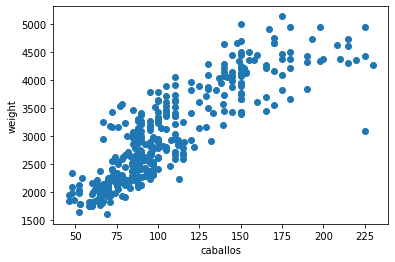

In [15]:
plt.figure()
plt.scatter(cars2["hp"], cars2["weight"])
plt.xlabel("caballos")
plt.ylabel("weight")
plt.show()

In [16]:
normalized = Normalizer(inputCol="features", outputCol="features_normalized", p=1.0 )

train_norm = normalized.transform(train)

train_norm.show(5)

+-------------+----+--------------------+
|     features| mpg| features_normalized|
+-------------+----+--------------------+
|[46.0,1950.0]|26.0|[0.02304609218436...|
|[49.0,1867.0]|29.0|[0.02557411273486...|
|[52.0,1649.0]|31.0|[0.03057025279247...|
|[52.0,2035.0]|29.0|[0.02491614758025...|
|[53.0,1795.0]|33.0|[0.02867965367965...|
+-------------+----+--------------------+
only showing top 5 rows



In [17]:
standard_scaler = StandardScaler(inputCol="features", outputCol="features_scaled")
train_model = standard_scaler.fit(train)
train_scaled = train_model.transform(train)
train_scaled.show(5, truncate=False)
test_scaled = train_model.transform(test)
test_scaled.show(5, truncate=False)

+-------------+----+---------------------------------------+
|features     |mpg |features_scaled                        |
+-------------+----+---------------------------------------+
|[46.0,1950.0]|26.0|[1.1834806214718219,2.2410785206038866]|
|[49.0,1867.0]|29.0|[1.2606641402634624,2.1456890245986955]|
|[52.0,1649.0]|31.0|[1.3378476590551032,1.8951479387055432]|
|[52.0,2035.0]|29.0|[1.3378476590551032,2.338766558681492] |
|[53.0,1795.0]|33.0|[1.3635754986523165,2.062941509991783] |
+-------------+----+---------------------------------------+
only showing top 5 rows

+-------------+----+---------------------------------------+
|features     |mpg |features_scaled                        |
+-------------+----+---------------------------------------+
|[46.0,1835.0]|26.0|[1.1834806214718219,2.108912351440068] |
|[54.0,2254.0]|23.0|[1.3893033382495301,2.5904569156108517]|
|[60.0,1834.0]|27.0|[1.5436703758328112,2.1077630804038607]|
|[65.0,1773.0]|31.0|[1.672309573818879,2.0376575471952263] |

In [18]:
lr = LinearRegression(featuresCol="features_scaled", labelCol = "mpg", maxIter=100)

lrModel =lr.fit(train_scaled)

print(lrModel.coefficients)
print(lrModel.intercept)

trainingSum = lrModel.summary

print(trainingSum.r2)
print(trainingSum.rootMeanSquaredError)

[-1.85348913462913,-5.089701006065463]
45.99498987050928
0.7240140258467107
4.167095592881394


In [24]:
lrModel.transform(test_scaled).show(5)

+-------------+----+--------------------+-----------------+
|     features| mpg|     features_scaled|       prediction|
+-------------+----+--------------------+-----------------+
|[46.0,1835.0]|26.0|[1.18348062147182...|33.06768808073873|
|[54.0,2254.0]|23.0|[1.38930333824953...|30.23528005880601|
|[60.0,1834.0]|27.0|[1.54367037583281...|32.40592973057513|
|[65.0,1773.0]|31.0|[1.67230957381887...|32.52431457772329|
|[72.0,3158.0]|15.0|[1.85240445099937...|24.08902803998986|
+-------------+----+--------------------+-----------------+
only showing top 5 rows



REGRESIÓN LOGÍSTICA

In [25]:
data = spark.read.csv("/content/titanic.csv", inferSchema = True, header = True)

In [26]:
data.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [27]:
my_cols = data.select([
 'Survived',
 'Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked'])

my_final_data = my_cols.na.drop()



In [28]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)

gender_indexer = StringIndexer(inputCol='Sex',outputCol='SexIndex')
gender_encoder = OneHotEncoder(inputCol='SexIndex',outputCol='SexVec')

embark_indexer = StringIndexer(inputCol='Embarked',outputCol='EmbarkIndex')
embark_encoder = OneHotEncoder(inputCol='EmbarkIndex',outputCol='EmbarkVec')

assembler = VectorAssembler(inputCols=['Pclass',
 'SexVec',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'EmbarkVec'],outputCol='features')

from pyspark.ml.classification import LogisticRegression

In [29]:
from pyspark.ml import Pipeline

log_reg_titanic = LogisticRegression(featuresCol="features", labelCol="Survived")

pipeline = Pipeline(stages=[gender_indexer, gender_encoder, embark_indexer, embark_encoder, assembler, log_reg_titanic ])

train, test = my_final_data.randomSplit([0.7, 0.3])

fit = pipeline.fit(train)

results =fit.transform(test)

results.select("Survived", "prediction").show()

+--------+----------+
|Survived|prediction|
+--------+----------+
|       0|       1.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       1.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
+--------+----------+
only showing top 20 rows



In [30]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

eval = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="Survived")

auc = eval.evaluate(results)

auc

0.7760552496860813

DECISION TREE CLASSIFIER Y RANDOM FOREST

In [32]:
data = spark.read.csv("/content/College.csv", inferSchema = True, header = True)

assembler = VectorAssembler(
  inputCols=['Apps',
             'Accept',
             'Enroll',
             'Top10perc',
             'Top25perc',
             'F_Undergrad',
             'P_Undergrad',
             'Outstate',
             'Room_Board',
             'Books',
             'Personal',
             'PhD',
             'Terminal',
             'S_F_Ratio',
             'perc_alumni',
             'Expend',
             'Grad_Rate'],
              outputCol="features")

output = assembler.transform(data)

In [33]:
indexer = StringIndexer(inputCol="Private", outputCol="PrivateIndex")

outputfixed = indexer.fit(output).transform(output)

finaldata = outputfixed.select("features", "PrivateIndex")

train, test = finaldata.randomSplit([0.7, 0.3])

In [34]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier

dt = DecisionTreeClassifier(labelCol="PrivateIndex", featuresCol="features")
rf = RandomForestClassifier(labelCol="PrivateIndex", featuresCol="features")

dtmodel = dt.fit(train)
rfmodel = rf.fit(train)

In [35]:
dtpred =dtmodel.transform(test)
rfpred = rfmodel.transform(test)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc_eval = MulticlassClassificationEvaluator(labelCol="PrivateIndex", predictionCol="prediction", metricName = "accuracy")

dtacc = acc_eval.evaluate(dtpred)
rfacc = acc_eval.evaluate(rfpred)

In [36]:
print(dtacc*100)
print(rfacc*100)

91.88034188034187
93.58974358974359


K-MEANS

In [39]:
dataset = spark.read.csv("/content/seeds_dataset.csv", header =True, inferSchema =True)

from pyspark.ml.clustering import KMeans

vec_assembler = VectorAssembler(inputCols= dataset.columns, outputCol= "features")

finaldata = vec_assembler.transform(dataset)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(finaldata)
final_data = scalerModel.transform(finaldata)

In [42]:
kmedias = KMeans(featuresCol="scaledFeatures", k=3)

model = kmedias.fit(final_data)

centers = model.clusterCenters()

for center in centers:
  print(center)

model.transform(final_data).select("prediction").show()

[ 4.96198582 10.97871333 37.30930808 12.44647267  8.62880781  1.80061978
 10.41913733]
[ 4.07497225 10.14410142 35.89816849 11.80812742  7.54416916  3.15410901
 10.38031464]
[ 6.35645488 12.40730852 37.41990178 13.93860446  9.7892399   2.41585013
 12.29286107]
+----------+
|prediction|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         2|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         1|
+----------+
only showing top 20 rows



SPARK STREAMING

In [45]:
from pyspark.sql.types import *

schema = StructType([
StructField("person_ID",IntegerType(),True), 
StructField("name",StringType(),True), 
StructField("first",StringType(),True),
StructField("last", StringType(), True),
StructField("middle", StringType(), True),
StructField("email", StringType(), True),
StructField("phone", StringType(), True),
StructField("fax", StringType(), True),
StructField("title", StringType(), True)])

people_df = spark.readStream.format("csv").schema(schema).option("header", True).load("streaming")

results_df = people_df.select("*")

query = (results_df.writeStream
.format("json")
.queryName("selectTable")
.option("checkpointLocation", "checkpoint")
.option("path", "results")
.outputMode("append")
.start()
.awaitTermination() 
)

KeyboardInterrupt: ignored